# 临时设置代理

In [3]:
import torch
a = torch.empty(1,1)
a.size()

torch.Size([1, 1])

In [1]:
import os

# 设置 HTTP/HTTPS 代理（根据你的代理地址修改）
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tokenizers import Tokenizer
class TransformerDataset(Dataset):
    
    def __init__(self, 
                 ds, 
                 src_tokenizer: Tokenizer, 
                 tgt_tokenizer: Tokenizer, 
                 src_lang: str, 
                 tgt_lang: str, 
                 seq_len: int):
        super().__init__()
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.ds = ds
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.seq_len = seq_len
        
        self.sos_token = torch.tensor([self.src_tokenizer.token_to_id('[SOS]')], dtype = torch.int64)
        self.eos_token = torch.tensor([self.src_tokenizer.token_to_id('[EOS]')], dtype = torch.int64)
        self.pad_token = torch.tensor([self.src_tokenizer.token_to_id('[PAD]')], dtype = torch.int64)
    
    def __len__(self):
        return len(self.ds)
    
    
    def __getitem__(self, index):
        
        src_tgt_value_pair = self.ds[index]
        input_text = src_tgt_value_pair['translation'][self.src_lang]
        tgt_text = src_tgt_value_pair['translation'][self.tgt_lang]
        print(f'input text = {input_text}, \n翻译对应的文本 = {tgt_text}')
        src_tokens = self.src_tokenizer.encode(input_text).ids
        print(f'输入的文本encode的编码数字是: {src_tokens}')
        
        retry_decode = self.src_tokenizer.decode(src_tokens)
        print(retry_decode)
        tgt_tokens = self.tgt_tokenizer.encode(tgt_text).ids
        
        print(f'源头数据长度{len(src_tokens)}, 目标数据长度{len(tgt_tokens)}')
        
        src_pad_len = self.seq_len - len(src_tokens) - 2
        tgt_pad_len = self.seq_len - len(tgt_tokens) - 1
        if src_pad_len < 0 or tgt_pad_len < 0:
            raise ValueError('输入的文本长度大于模型输入长度')
        
        # 源 这行输入句子的input tensor
        src_tokens = torch.cat(
            [
                self.sos_token,
                torch.tensor(src_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * src_pad_len, dtype = torch.int64)
            ]
        )
        
        # tgt 训练 input tensor
        tgt_tokens = torch.cat(
            [
                self.sos_token,
                torch.tensor(tgt_tokens, dtype = torch.int64),
                torch.tensor([self.pad_token] * tgt_pad_len, dtype = torch.int64)
            ]
        )
        
        # label tensor
        label_tokens = torch.cat(
            [
                torch.tensor(tgt_tokens[1:], dtype = torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * tgt_pad_len, dtype = torch.int64)
            ]
        )
        
        # 源的mask： 遮挡PAD部分的数据
        src_mask = (src_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).int() # (1,1, seq_len) 
        
        # tgt_mask 遮挡当前词后面的词以及填充词
        tgt_mask = (tgt_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).int() & torch.tril(torch.ones((1, self.seq_len, self.seq_len), dtype=torch.int64))
        
        return {
            'encoder_input': src_tokens, # (seq_len,)
            'decoder_input': tgt_tokens, # (seq_len,)
            
            'encoder_mask': src_mask, # (1,1, seq_len)
            'decoder_mask': tgt_mask, # (1,1, seq_len) & (1, seq_len, seq_len) --> (1,seq_len, seq_len)
            'label': label_tokens, # (seq_len,)
            'src_text': input_text,
            'tgt_text': tgt_text,
        }
            
        
        

transformer_dataset = TransformerDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], 128)
print(len(transformer_dataset))
next(iter(transformer_dataset))

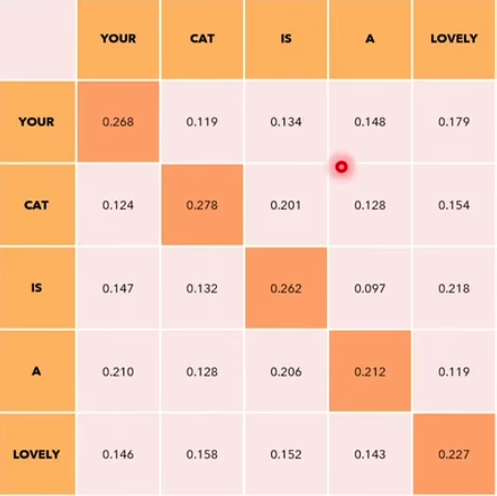

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [11]:
import torch
a = torch.tensor(11)
print(a)
print(torch.tensor([a] * 2, dtype=torch.float))

tensor(11)
tensor([11., 11.])


In [14]:
size = 5

torch.triu(torch.ones(1, size, size), diagonal=1)

tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [29]:
a = torch.tensor([[[1,1,1,0,0]]])
print(a.size())

b = a & torch.tril(torch.ones((1, size, size), dtype=torch.int32))
print(b.size())

torch.Size([1, 1, 5])
torch.Size([1, 5, 5])
